In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'html5'
from scipy.integrate import odeint

In [2]:
κ = 400
ρ = 8960
Cp = 386
tz = 0.01
σ = 5.670373e-8
ϵ = 0.5
hc = 1
Ta = 300
α = κ/(ρ*Cp)
α

0.00011565507031828275

In [3]:
width, height = 1, 1
nx, ny = 51, 51

x = np.linspace(0,width,nx)
y = np.linspace(0,height,ny)
X, Y = np.meshgrid(x, y)

dx = x[1] - x[0]
dy = y[1] - y[0]

In [4]:
T0 = np.zeros((ny,nx))

# Boundary conditions

+ Neumann condition - Zero heat flux on vertical faces (left and right) and top face
+ Dirichlet condition - Constant temperature, T = 1000 K on bottom edge

In [5]:
T0[0,:] = 1000

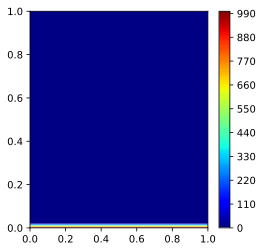

In [6]:
fig = plt.figure(figsize=(4,4))
temp = plt.contourf(X,Y,T0,levels=100,cmap=plt.cm.jet,origin='lower')
plt.colorbar(temp)

In [7]:
def diffusion2D(y,t,ny,nx,κ,ρ,Cp,α,dx,dy):
    dydt = np.empty_like(y)
    T = y.reshape((ny,nx))
    del2T = np.zeros((ny,nx))
    del2T[:,1:-1] += α*np.diff(T,n=2,axis=1)/dx**2
    del2T[1:-1,:] += α*np.diff(T,n=2,axis=0)/dy**2
    #del2T[1:-1,1:-1] = α*((T[1:-1,2:] - 2.*T[1:-1,1:-1] + T[1:-1,:-2])/dx**2. + (T[2:,1:-1] - 2.*T[1:-1,1:-1] + T[:-2,1:-1])/dy**2.)
    del2T[:,0] = α*(-2.*T[:,0] + 2.*T[:,1])/dx**2.
    del2T[:,-1] = α*(-2.*T[:,-1] + 2.*T[:,-2])/dx**2.
    del2T[-1,:] = α*(-2.*T[-1,:] + 2.*T[-2,:])/dy**2.
    del2T[0,:] = 0.
    dydt = del2T.ravel()
    
    return dydt

In [8]:
tspan = np.linspace(0,5000,501)

In [9]:
sol = odeint(diffusion2D, T0.ravel(), tspan, args=(ny,nx,κ,ρ,Cp,α,dx,dy))

In [10]:
sol.shape

(501, 2601)

In [11]:
T = sol.reshape((tspan.shape[0],ny,nx))

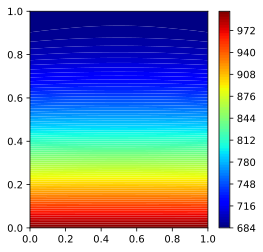

In [12]:
fig = plt.figure(figsize=(4,4),dpi=600)
temp = plt.contourf(X,Y,T[-1,:,:],levels=100,cmap=plt.cm.jet)
plt.colorbar(temp)

In [34]:
%timeit odeint(diffusion2D, T0.ravel(), tspan, args=(ny,nx,κ,ρ,Cp,α,dx,dy))

7.15 s ± 3.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit odeint(diffusion2D, T0.ravel(), tspan, args=(ny,nx,κ,ρ,Cp,α,dx,dy),ml=2,mu=2)

7.23 s ± 1.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
sola = odeint(diffusion2D, T0.ravel(), tspan, args=(ny,nx,κ,ρ,Cp,α,dx,dy))

In [14]:
solb = odeint(diffusion2D, T0.ravel(), tspan, args=(ny,nx,κ,ρ,Cp,α,dx,dy),ml=2,mu=2)

In [15]:
np.allclose(sola,solb)

True

# Including convective and radiative heat transfer

In [16]:
def diffusion2D_nonlinear(y,t,ny,nx,κ,ρ,Cp,α,hc,Ta,σ,ϵ,tz,dx,dy):
    dydt = np.empty_like(y)
    T = y.reshape((ny,nx))
    del2T = np.zeros((ny,nx))
    # diffusive heat transfer
    del2T[:,1:-1] += α*np.diff(T,n=2,axis=1)/dx**2
    del2T[1:-1,:] += α*np.diff(T,n=2,axis=0)/dy**2
    # convective heat transfer
    del2T[1:-1,1:-1] += (-2.*hc)*(T[1:-1,1:-1]-Ta)/(ρ*Cp*tz)
    # radiative heat transfer
    del2T[1:-1,1:-1] += (-2.*ϵ*σ)*(T[1:-1,1:-1]**4.-Ta**4.)/(ρ*Cp*tz)
                         
    del2T[:,0] = α*(-2.*T[:,0] + 2.*T[:,1])/dx**2.
    del2T[:,-1] = α*(-2.*T[:,-1] + 2.*T[:,-2])/dx**2.
    del2T[-1,:] = α*(-2.*T[-1,:] + 2.*T[-2,:])/dy**2.
    del2T[0,:] = 0.
    dydt = del2T.ravel()
    
    return dydt

In [17]:
sol = odeint(diffusion2D_nonlinear, T0.ravel(), tspan, args=(ny,nx,κ,ρ,Cp,α,hc,Ta,σ,ϵ,tz,dx,dy))

In [18]:
Temperature = sol.reshape((tspan.shape[0],ny,nx)) 

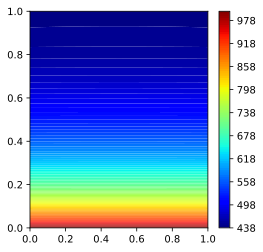

In [19]:
fig = plt.figure(figsize=(4,4),dpi=600)
temp = plt.contourf(X,Y,Temperature[-1,:,:],levels=100,cmap=plt.cm.jet)
plt.colorbar(temp)

# Steady State Solution

## Temperature as a function of the Y-Coordinate

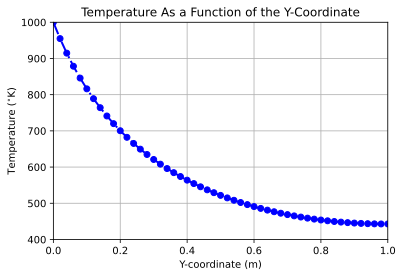

In [20]:
fig = plt.figure(figsize=(6,4), dpi=600, facecolor='w')
plt.plot(x,Temperature[-1,:,int(nx/2)],'b-.o',lw=2)
plt.xlabel('Y-coordinate (m)')
plt.ylabel('Temperature ($^{\circ}$K)')
plt.xlim([0,1])
plt.ylim([400,1000])
plt.title('Temperature As a Function of the Y-Coordinate')
plt.grid(True)

# Transient Solution

## Temperature along the Top Edge of the Plate as a Function of Time

In [21]:
Ttop = np.asarray(Temperature[:,-1,:])
Ttop.shape

(501, 51)

In [22]:
Ttop_avg = Ttop.mean(axis=1)
Ttop_avg.shape

(501,)

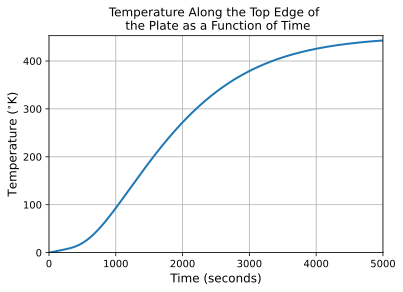

In [23]:
fig = plt.figure(figsize=(6,4), dpi=600, facecolor='w')
plt.plot(tspan,Ttop_avg,lw=2)
plt.xlabel('Time (seconds)',fontsize=12)
plt.ylabel('Temperature ($^{\circ}$K)',fontsize=12)
plt.xlim([0,5000])
plt.ylim([Ttop_avg.min(),Ttop_avg.max()+10])
plt.title(f'Temperature Along the Top Edge of \n the Plate as a Function of Time')
plt.grid(True)

In [24]:
print(f'Temperature at the top edge after t = {tspan[-1]:5.1f} s = {Ttop_avg[-1]:5.1f} K')

Temperature at the top edge after t = 5000.0 s = 442.8 K
